Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejores hiperparámetros:
{'alpha': 0.01}
Mean Squared Error en validación: 16.750342447107773
4.0927182222952725


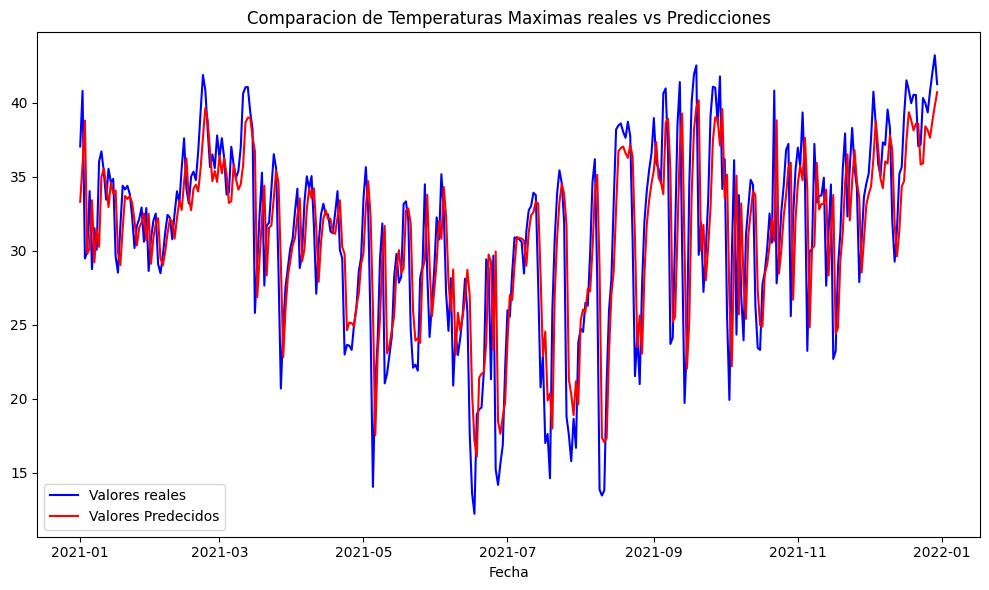

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Cargar el dataset
data = pd.read_csv("C:/Users/colma/OneDrive/GoodNotes/FIUNA/Optativas/Inteligencia Artificial/PC - Github/Primer-Parcial-IA/Temp_Asu20092021.csv")

# Convertir la columna 'Fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019 en adelante
data = data[data.index.year >= 2019]

# Eliminar filas con valores faltantes
data.dropna(inplace=True)

# Resamplear el conjunto de datos a intervalos diarios y calcular la temperatura máxima diaria
daily_max_temperatures = data['Temperatura'].resample('D').max()
salida= daily_max_temperatures .shift(-1)

# Agregar algunas caracteristicas adicionales como temperaturas de dias anteriores , medias de 3 y 7 dias.
# Temperatura del dia anterior 2 dias antes y 7 dias antes (Lag Features : caracteristicas que representan las temperaturas de dias anteriores)
lag_1 = daily_max_temperatures.shift(1) #Desplaza todo una fila abajo
lag_2 = daily_max_temperatures.shift(3)
lag_3 = daily_max_temperatures.shift(7)

#Medias móviles
mediamov_3 = daily_max_temperatures.rolling(window = 3).mean()
mediamov_7 = daily_max_temperatures.rolling(window = 7).mean()

#Data frame con caracteristicas adicionales

X = pd.DataFrame({
    'temp_max' : daily_max_temperatures.values,
    'lag_1' : lag_1.values,
    'lag_2' : lag_2.values,
    'lag_3' : lag_2.values,
    'mediamov_3' : mediamov_3.values,
    'mediamov_7' : mediamov_7.values,
})


# Definir características (features) y variable objetivo (target)
X = daily_max_temperatures.values[:-1]  # Puedes agregar más características según sea necesario
y = salida.values[:-1]

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1,1))

#Eliminar el ultimo valor de las fecgas para alinearlo con X e y 

fechas = daily_max_temperatures.index[:-1]

# Dividir los datos en conjuntos de entrenamiento y validación
train_indices = fechas.year <= 2020
val_indices = fechas.year == 2021

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]


# Definir el modelo de regresión Ridge
ridge = Ridge()

# Definir la cuadrícula de parámetros para GridSearch
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularización L2
}

# Usar GridSearchCV para buscar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error en validación: {mse}")
print(np.sqrt(mse))
#Graficando tenemos 
val_dates = fechas[val_indices]
plt.figure(figsize=(10,6))
plt.plot(val_dates , y_val , label = 'Valores reales' , color = 'blue' )
plt.plot(val_dates , y_pred , label = 'Valores Predecidos' , color = 'red')
plt.xlabel('Fecha')
plt.legend('Temperatura Maxima')
plt.title('Comparacion de Temperaturas Maximas reales vs Predicciones')
plt.legend()
plt.tight_layout()
plt.show()